<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/SIR_mode_natimm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

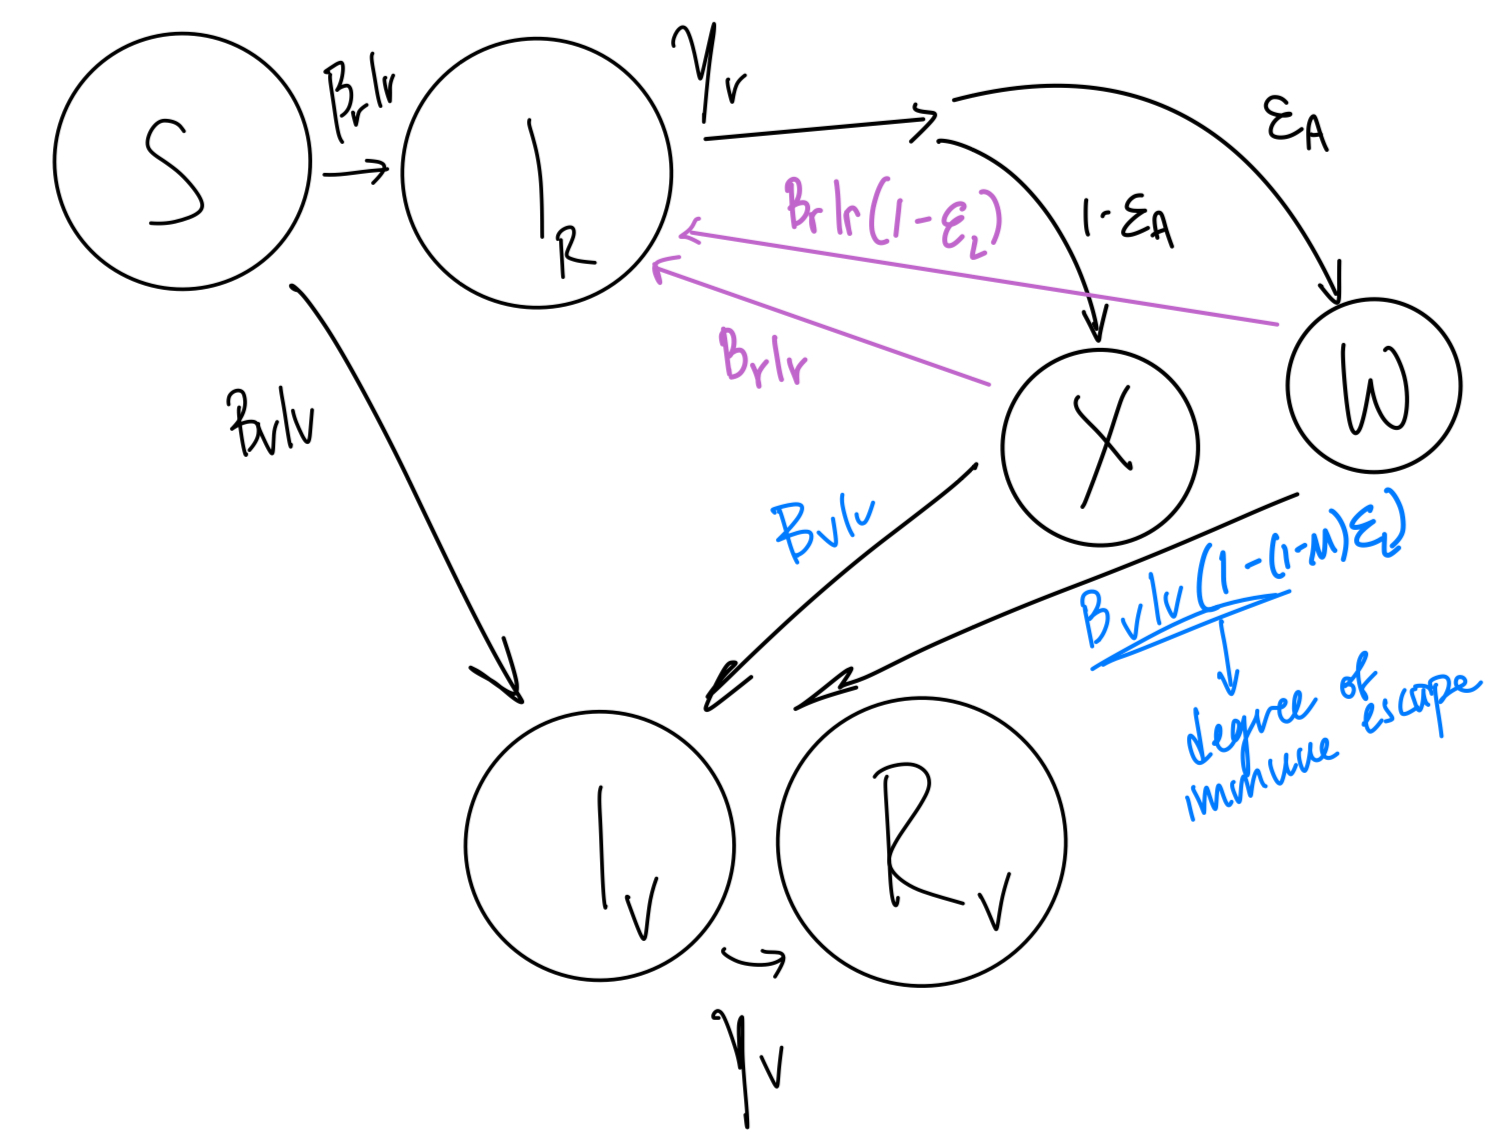

$\frac{\mathrm{d}S}{\mathrm{d}t} = -(\beta_r I_r + \beta_v I_v)S$

$\frac{\mathrm{d}I_r}{\mathrm{d}t} = \beta_r I_r [S+X+(1-\epsilon_L) W] - \gamma_r I_r $

$\frac{\mathrm{d}X}{\mathrm{d}t} = (1-\epsilon_a)\gamma_rI_r - (\beta_v I_v + \beta_r I_r) X $

$\frac{\mathrm{d}W}{\mathrm{d}t} = \epsilon_a\gamma_rI_r - \beta_r I_r(1-\epsilon_L) - \beta_v I_v (1-(1-\mu)\epsilon_L) W$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \beta_v I_v [S + X + (1-(1-\mu)\epsilon_L)] W - \gamma_v I_v$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \gamma_v I_v$

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [76]:
# SIR model equations
def SIR_model_rv(t, y, mu, betar, gammar, betav, gammav, epsilona, epsilonL):
    S, Ir, X, W, Iv, Rv,  = y
    dSdt = -(betar*Ir + betav*Iv) * S
    dIrdt = betar * Ir * (S + X + (1-epsilonL)*W)  - gammar * Ir

    dXdt = (1-epsilona)*gammar * Ir - (betav*Iv+betar*Ir)*X
    dWdt = epsilona * gammar * Ir - betar*Ir*(1-epsilonL)*W - betav*Iv*(1-(1-mu)*epsilonL)*W

    dIvdt = betav*Iv*(S + X + betav*Iv*(1-(1-mu)*epsilonL)*W) - gammav * Iv
    dRvdt = gammav * Iv

    #code in progress to get sus and imm
    #dCsdt = #cumulative from susceptible residents
    #dCidt = betar #cumulative from immune

    return [dSdt, dIrdt, dXdt, dWdt, dIvdt, dRvdt]


def plot_basic(solution, figsize = (10,6)):
  t = solution.t
  S, Ir, X, W, Iv, Rv = solution.y

  plt.figure(figsize=figsize)
  plt.plot(t, S, label='Susceptible')
  plt.plot(t, Ir, label='Infected (original)')
  plt.plot(t, Iv, label='Infected (variant)')
  plt.plot(t, Rv, label='Recovered (variant)')
  plt.plot(t, X, label='Immunity_none')
  plt.plot(t, W, label='Immunity_leaky')


  plt.xlabel('Time (days)')
  plt.ylabel('Proportion of Population')
  plt.title('SIR Model Simulation with Variant')
  plt.legend()
  plt.grid(True)
  plt.show


##COMPARING INFECTEDS AMONG LEAKY AND AON

def plot_infecteds(solution_leaky, solution_aon, figsize=(15, 6)):
  if solution_leaky.t[-1] != solution_aon.t[-1] or solution_leaky.t[0] != solution_aon.t[0]:
    raise Exception("Differing timescales")

  t = solution_leaky.t
  leakyS, leakyIr, leakyX, leakyW, leakyIv, leakyRv = solution_leaky.y
  aonS, aonIr, aonX, aonW, aonIv, aonRv = solution_aon.y

  # comparing infected population
  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)
  ax1.plot(t, leakyIr, label='$I_r$ - leaky', alpha=0.5, color = 'blue')
  ax1.plot(t, aonIr, label='$I_r$ - AoN', alpha=0.5, color = 'green')

  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel('Prevalence')
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)

  #variant subplot
  ax2 = fig.add_subplot(122, axisbelow=True)

  ax2.plot(t, leakyIv, label='$I_v$ - leaky', alpha=0.5, color = 'blue')
  ax2.plot(t, aonIv, label='$I_v$ - AoN', alpha=0.5, color = 'green')

  ax2.set_xlabel('Time (days)')
  ax2.set_ylabel('Prevalence')
  ax2.grid(linewidth=0.5)
  legend = ax2.legend()
  legend.get_frame().set_alpha(0.5)


# 1. Basic SIR model with perfect natural immunity only
W as the absorbing compartment. Behaviour should resemble SIR model, with W as traditional R. Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in W and Ir) is influenced by beta and indirectly affected by R0 and recovery rate.

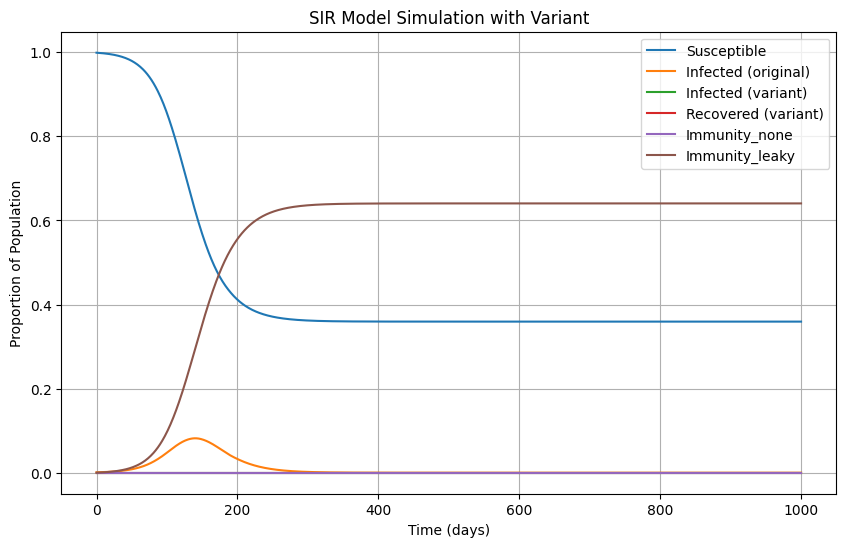

In [47]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught

#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
betav = 1
gammav = 1
Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.001

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)

# 2. One strain model with no natural immunity using X compartment

X as the recovery compartment, meaning full susceptibility. We eventually reach an equilibrium state where rate of recovery matches rate of transmission, but infection never dies out..


Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in W and Ir) is influenced by beta and indirectly affected by R0 and recovery rate.

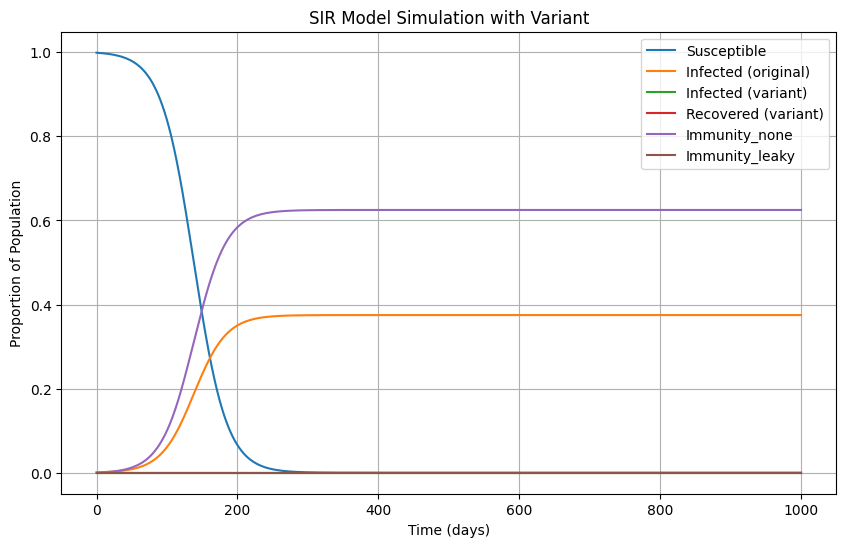

In [46]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
betav = 1
gammav = 1
Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 0
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.001

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)


# 2.5 One strain model with no natural immunity

W as the only recovery compartment, but with epsilonL = 0, meaning full susceptibility. We eventually reach an equilibrium state where rate of recovery matches rate of transmission, but infection never dies out. Behaviour should match the previous scenario exactly when params are the same as well.


Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in W and Ir) is influenced by beta and indirectly affected by R0 and recovery rate.

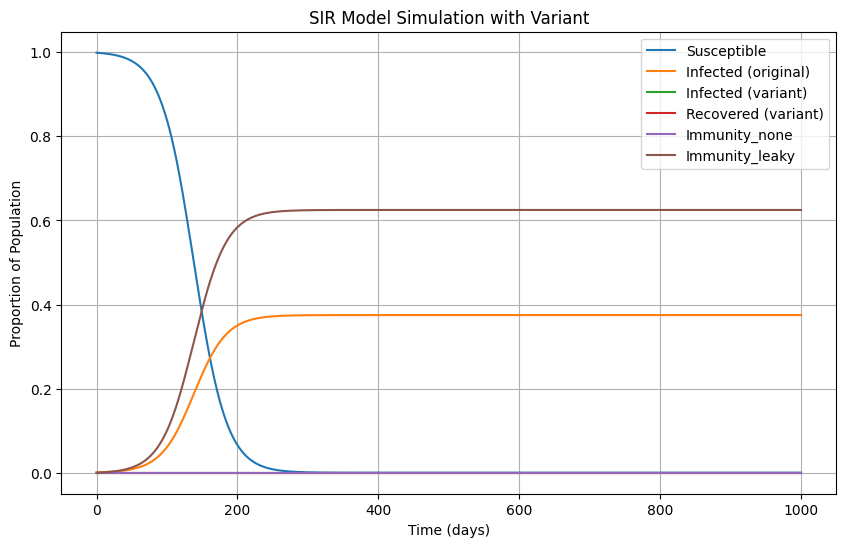

In [45]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
betav = 1
gammav = 1
Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 1
epsilonL = 0
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.001

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)




# 3. One strain model with leaky immunity only

W as the recovery compartment, with leaky susceptibility 0 < epsilon_L < 1. Infection eventually dies out unless at high leakiness (epsilon_L closer to 0).

**define relationship between dying out and leakiness???**


Unlike prior models, where infection dies out because there is nobody left susceptible, infection dying out is contingent on the infected compartment reaching 0 as there is no absorbing compartment.


Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in W and Ir) is influenced by beta and indirectly affected by R0 and recovery rate.

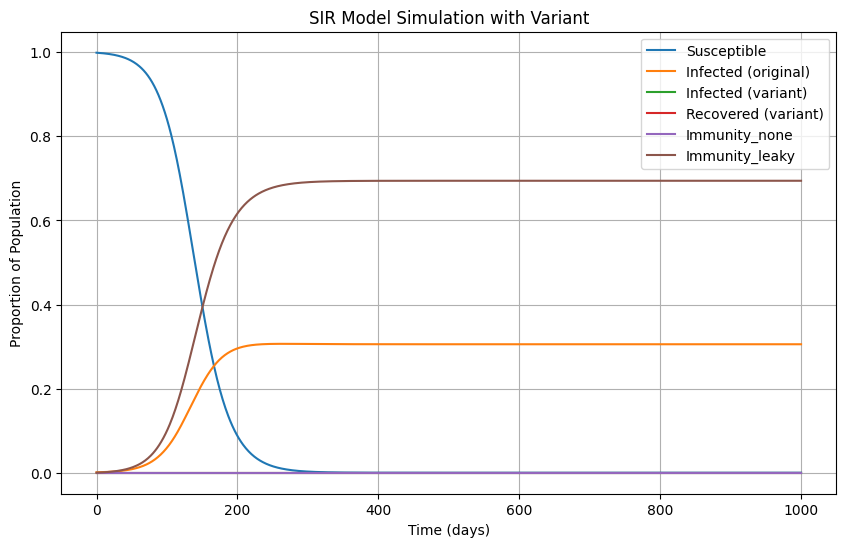

In [44]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
betav = 1
gammav = 1
Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 1
epsilonL = 0.1
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.001

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)



# 4. One strain model with all or nothing protection. epsilon_A = 0.5


Infection dies out because more and more are absorbed into W, perfect protection compartment. This can be seen as W's curve grows visibly more and for longer comparted to X, matching the decrease in infected. Population gradually becomes less susceptible until Ir = 0. Note people in X are still susceptible, though W outweighs X due to W's perfect protection.

Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in W and Ir) is influenced by beta and indirectly affected by R0 and recovery rate.

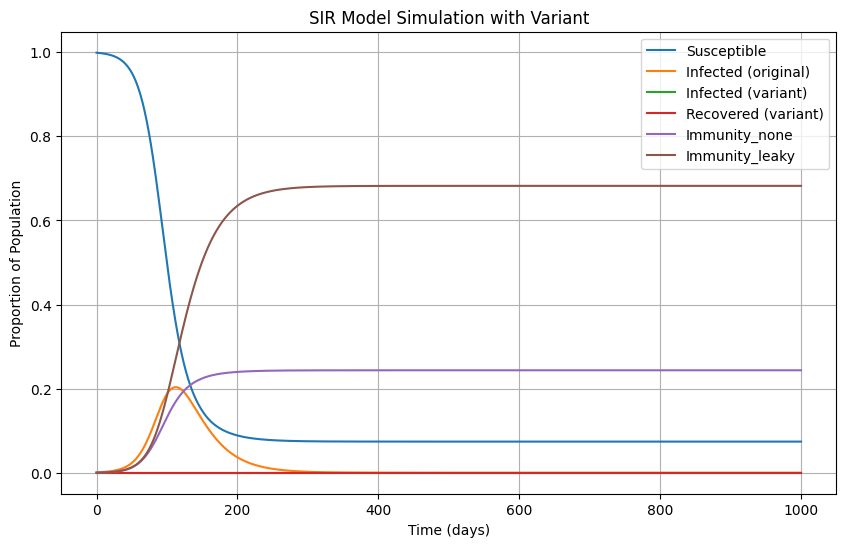

In [43]:
# set parameter values
#betar = 1.1
Rrnaught = 1.9
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
betav = 1
gammav = 1
Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 0.5
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.001

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)

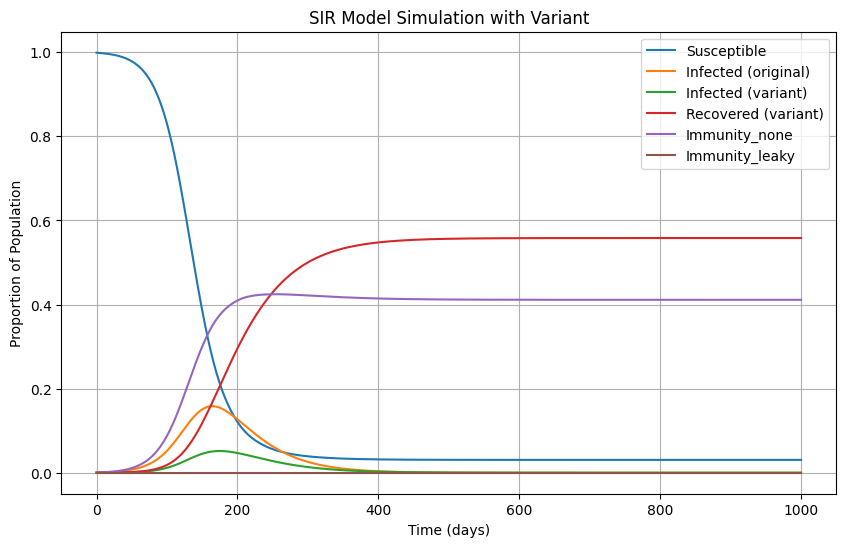

# 5. One strain model with 2 modes of imperfect protection: leaky [epsilon_L ϵ (0,1) ] and no natural immunity. epsilon_A = 0.5


Infection doesn't die out because (gammaR)(Ir) = BrIr(S+X+(1-Ea)W) —that is, recovery rates match transmission.


Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in W and Ir) is influenced by beta and indirectly affected by R0 and recovery rate.

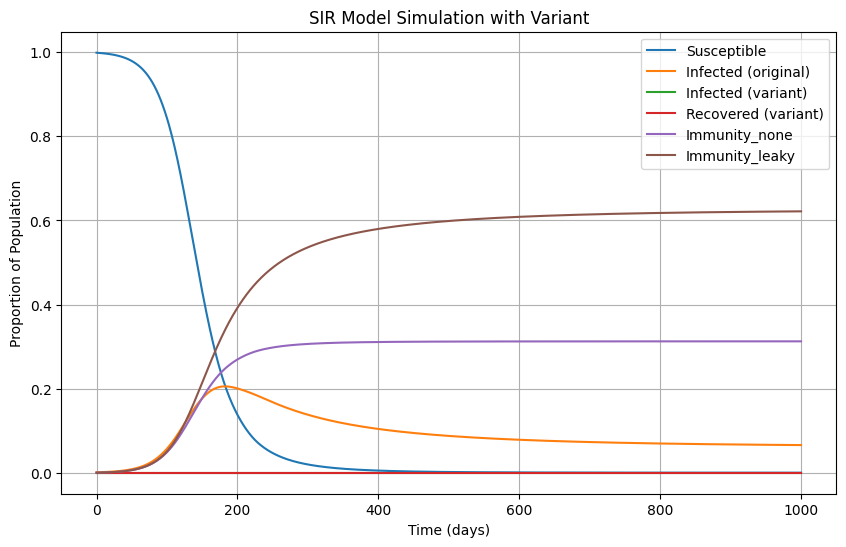

In [48]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
betav = 1
gammav = 1
Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 0.5
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.001

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)


# 6. Two-strain model, variant exists at t=0. Natural immunity confers perfect protection against all variants.

Similar to equivalent one-strain model, but both W and R_v absorbs all.

Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in W and Ir) is influenced by beta and indirectly affected by R0 and recovery rate.

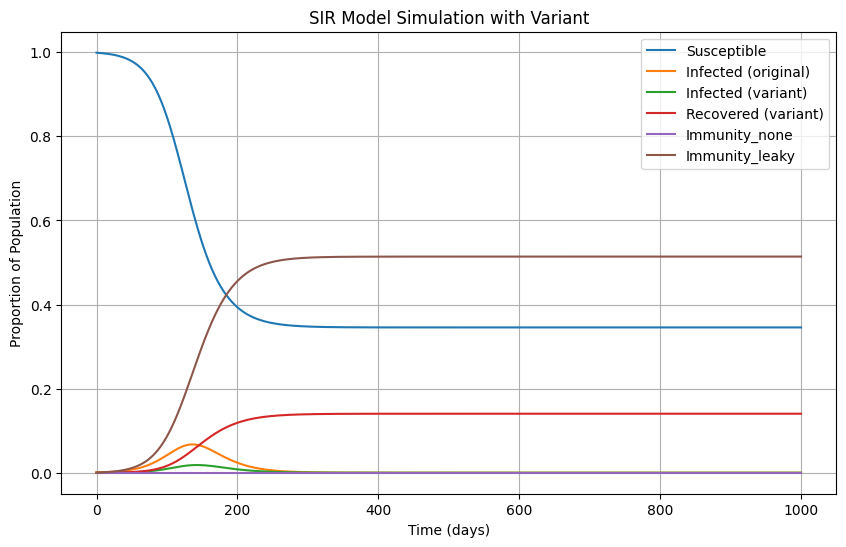

In [49]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
Rvnaught = 1.7
gammav = 1/14
betav = Rvnaught*gammav
#Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.0009

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)


# 7. Two-strain model, variant exists at t=0. Natural immunity confers no protection against any variants, with X.

Will see a lot more R_v compared to previous scenario, as the only absorbing compartment. Infected reaches higher final epidemic size and faster as more of the population stays susceptible for longer compared to previous scenario 6.

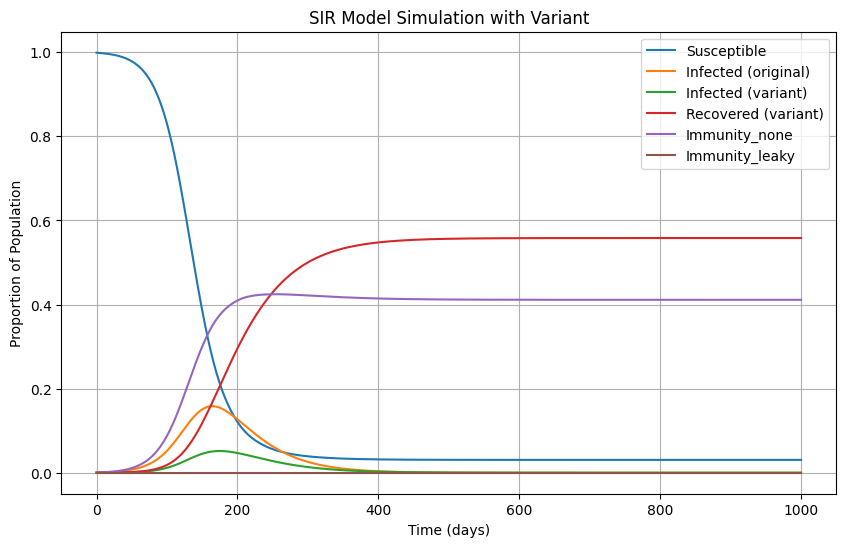

In [77]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
Rvnaught = 1.7
gammav = 1/14
betav = Rvnaught*gammav
#Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 0
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.0009

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)



# 8. Two-strain model, variant exists at t=0. All-or-nothing immunity (epsilon_A = 0.5)


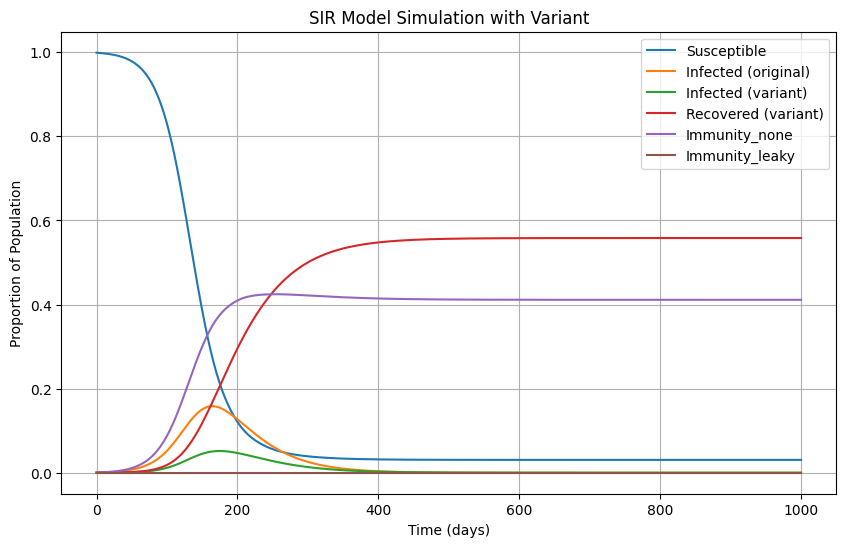

In [63]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
Rvnaught = 1.7
gammav = 1/14
betav = Rvnaught*gammav
#Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 0.5
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.0009

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution_aon = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)
plot_basic(solution)



# 8. Two-strain model, variant exists at t=0. Leaky immunity (epsilon_A = 0.0, epsilon_L ϵ (0,1))

Greater epidemic size than all-or-nothing model

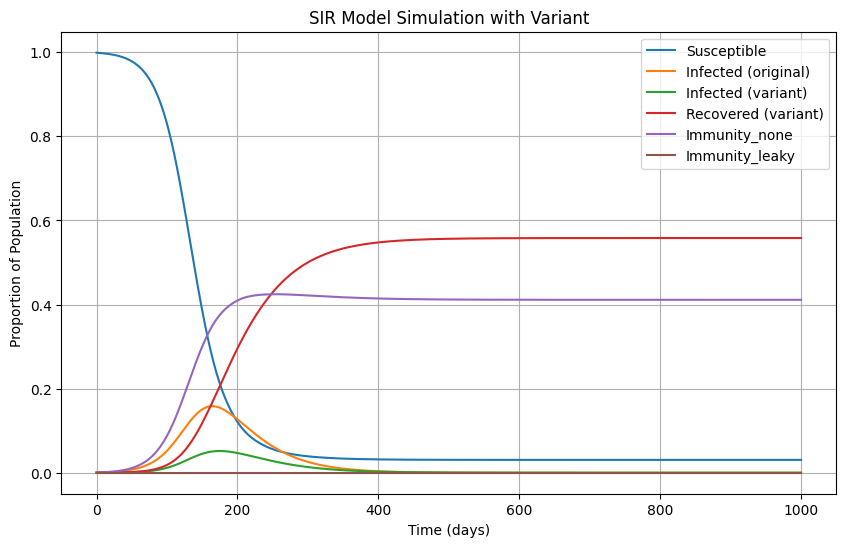

In [62]:
# set parameter values
#betar = 1.1
Rrnaught = 1.6
gammar = 1/14
betar = gammar*Rrnaught
#Rrnaught = betar / gammar # R0 for residents with entirely susceptible population

#following variant params do not matter for this scenario
Rvnaught = 1.7
gammav = 1/14
betav = Rvnaught*gammav
#Rvnaught = betav / gammav # R0 for variant with entirely susceptible population

mu = 0
epsilona = 0
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999
Ir0 = 0.0009

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution_leaky = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)
plot_basic(solution)


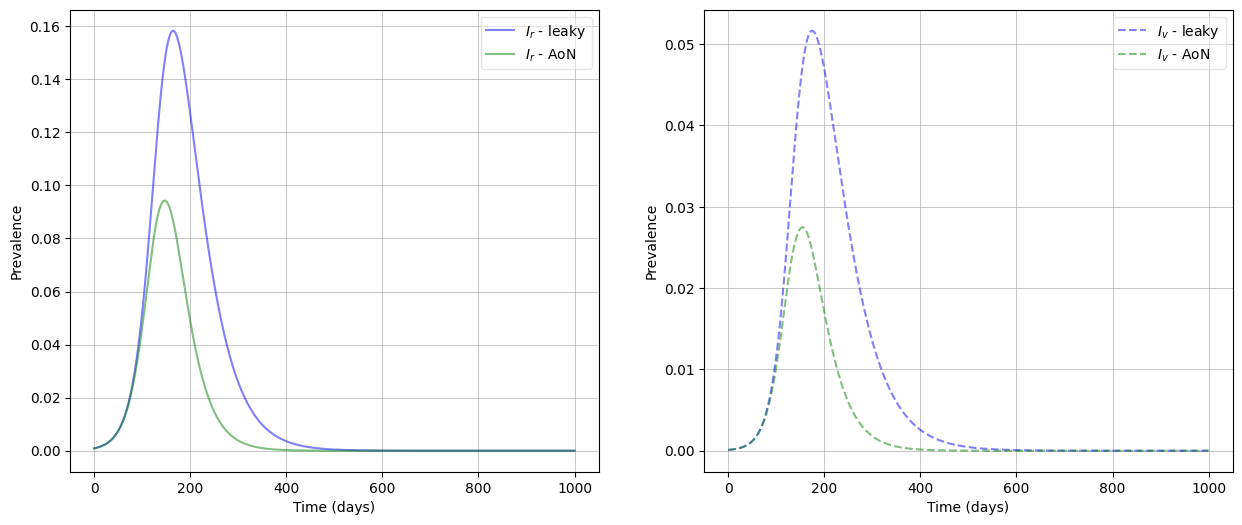

In [72]:
plot_infecteds(solution_leaky, solution_aon)